# SIMPLE tutorial

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

# update matplotlib params for bigger font
import matplotlib.pylab as pylab
params = {'mathtext.fontset': 'stix',
         'font.family': 'STIXGeneral'}
pylab.rcParams.update(params)

In [9]:
from simple.simple import LognormalIntensityMock

In [10]:
from astropy.cosmology import Planck18 as cosmo
import astropy.units as u
import astropy.constants as const
from astropy.table import Table

import numpy as np
import yaml
import os

from scipy.integrate import quad

## Run manually

### Define the luminosity function

The function has to be dimensionless, i.e. the input is given in units of the defined `luminosity_unit` and the output will be in units of $\frac{1}{\mathrm{Mpc}^3\mathrm{luminosity\_unit}}$.
It is best to use a typical luminosity for `luminosity_unit` so that the numerical errors of the integration will be small.

In [11]:
luminosity_unit = 1e42 * u.erg / u.s

def luminosity_function(L):
    """
    Calculates dn/dL (L), where L must be in units of luminosity_unit.
    For integration purposes, make sure that L/luminosity_unit is typically
    a small number, so that the numbers don't overflow in the integration.
    For example, luminosity_unit could be the mean expected luminosity.

    Luminosity function from Konno et al. (2016).
    """
    Lstar = (4.87 * luminosity_unit).to(luminosity_unit).value # 1e42 erg / s
    phistar = 3.37 * 1e-4 # Mpc-3
    alpha = -1.8

    return phistar * (L/Lstar)**alpha * np.exp(-L/Lstar) * 1/Lstar


We will save the luminosity function in a table so that we can later initiate the `LognormalIntensityMock` instance from files.

In [12]:
max_L_for_saving = 1e45 * u.erg / u.s
Lmin = 1e40 * u.erg / u.s
if np.isfinite(max_L_for_saving):
    max_log10_L_for_saving = np.log10(
        max_L_for_saving.to(luminosity_unit).value)
else:
    max_log10_L_for_saving = np.log10((1e5 * Lmin).to(luminosity_unit).value)
min_log10_L_for_saving = np.log10(Lmin.to(luminosity_unit).value)
N_save = 10000
dlog_10_L = (max_log10_L_for_saving - min_log10_L_for_saving) / N_save
log_10_Ls = np.linspace(min_log10_L_for_saving, max_log10_L_for_saving, N_save)

lum_tab = Table()
lum_tab["L"] = 10**log_10_Ls
lum_tab["dn/dL"] = luminosity_function(10**log_10_Ls)
lum_tab.write("luminosity_function_example.csv",
              format="csv", overwrite=True)

### Set up input parameters

It is possible to initiate a `LognormalIntensityMock` instance from a dictionary or from a yaml file that contains this dictionary.

In [13]:
input_dict = {"verbose" : False,
              "bias" : 1.5,
              "redshift" : 2.0,
              "single_redshift" : False,
              "box_size" : np.array([400,400,400]) * u.Mpc,
              "N_mesh" : np.array([128,128,128]),
              "luminosity_unit" : luminosity_unit,
              "Lmin" : 2e41 * u.erg/u.s,
              "Lmax" : np.inf * u.erg/u.s,
              "galaxy_selection" : {"intensity" : "all",
                                    "n_gal" : "detected"},
              "lambda_restframe" : 1215.67 * u.angstrom,
              "brightness_temperature" : False,
              "do_spectral_smooth" : True,
              "do_spectral_tophat_smooth" : False,
              "do_angular_smooth" : True,
              "sigma_beam" : 6 * u.arcsec,
              "dlambda" : 5 * u.angstrom,
              "footprint_radius" : 9 * u.arcmin,
              "luminosity_function" : luminosity_function,
              "run_pk" : {"intensity": True,
                        "n_gal": True,
                        "cross": True,
                        "sky_subtracted_cross": True
                            },
              "dk" : 0.04,
              "kmin" : 0.04,
              "kmax" : 1.0,
              "seed_lognormal" : 100,
              "outfile_prefix" : 'mock',
              "cosmology" : cosmo,
              "RSD" : True,
              "out_dir" : "../tmp/mocks/",
              "min_flux" : 3e-17 * u.erg/u.s/u.cm**2,
              "sigma_noise" : 2e-22 * u.erg/u.s/u.cm**2/u.angstrom/u.arcsec**2,
}

### Initiate the LognormalIntensityMock instance 

with the input dictionary:

In [14]:
lim = LognormalIntensityMock(input_dict)

Or initiate the `LognormalIntensityMock` instance from a yaml file that contains the input dictionary.
 In this case, the cosmology must be specified in a file or a dictionary that can be evaluated by astropy to construct a cosmology object or as a string that is part of the astropy cosmology collection, such as `Planck18`.
The luminosity function also has to be specified as the name of the file that contains the tabulated luminosity function.

In [15]:
lim = LognormalIntensityMock("example_input_file.yaml")

2023-07-12 15:43:04,954 simple WARNING: We extrapolate the values outside of the provided tabulated values of L. 
Plot plt.loglog(Ls, lim.luminosity_function(Ls)) in a reasonable range to check the outcome!


### Run the lognormal galaxy simulation from lognognormal_galaxies and load the catalog:

In [16]:
lim.run_lognormal_simulation_cpp()
lim.load_lognormal_catalog_cpp(
                bin_filename=lim.lognormal_bin_filename)

[0.   0.   0.06] eV
{'ofile_prefix': 'mock', 'inp_pk_fname': '../tmp/mocks/inputs/mock_pk.txt', 'xi_fname': '../tmp/mocks/inputs/mock_Rh_xi.txt', 'pkg_fname': '../tmp/mocks/inputs/mock_pkG.dat', 'mpkg_fname': '../tmp/mocks/inputs/mock_mpkG.dat', 'cpkg_fname': '../tmp/mocks/inputs/mock_mpkG.dat', 'f_fname': '../tmp/mocks/inputs/mock_fnu.txt', 'z': 2.0, 'mnu': 0.06, 'oc0h2': 0.11934063901639999, 'ob0h2': 0.0224178568132, 'ns': 0.9645, 'lnAs': 3.094, 'h0': <Quantity 0.6766>, 'w': -1.0, 'run': 0.0, 'bias': 1.5, 'bias_mpkG': 1.0, 'bias_cpkG': 1.35, 'Nrealization': 1, 'Ngalaxies': 279657, 'Lx': 270.64000000000004, 'Ly': 270.64000000000004, 'Lz': 270.64000000000004, 'rmax': 10000.0, 'seed': 100, 'Pnmax': 128, 'losy': 0.0, 'losz': 0.0, 'kbin': 0.01, 'kmax': 0.0, 'lmax': 4, 'gen_inputs': True, 'run_lognormal': True, 'calc_pk': False, 'calc_cpk': False, 'use_cpkG': 0, 'output_matter': 0, 'output_gal': 1, 'calc_mode_pk': 0, 'out_dir': '../tmp/mocks/', 'halofname_prefix': '', 'imul_fname': '', 'nu

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG

real	0m0.017s
user	0m0.005s
sys	0m0.006s

real	0m0.035s
user	0m0.027s
sys	0m0.004s

real	0m0.055s
user	0m0.016s
sys	0m0.006s

real	0m0.022s
user	0m0.016s
sys	0m0.005s


-------------beginning generate_poisson---------------------
Setting up the arrays.......
n0,n1,n2=128	128	128
size of Fourier grid is (n0,n1,n2)
(128,128,128)
Fourier resolution is 2.11438[Mpc/h]
Lx 270.64
Ly 270.64
Lz 270.64
kF0 0.023216
Generating mock density field in k-space
Finished generating mock density field.
Doing FFT for density field.
Done FFT for density field.
Average of Log-normal density field  :-3.05271e-09
Variance of Log-normal density field :1568.33
Average of Log-normal density field  :-1.45565e-15
Variance of Log-normal density field :1.08298
Average of matter Log-normal density field :-4.62067e-10
Variance of matter Log-normal density field :1197.7
Average of matter Log-normal density field :-2.20331e-16
Variance of matter Log-normal density field :0.82705
density maximum = 153.52
density minimum = -0.997805
Average of density field: 0.00100348
Variance of density field: 2.26557
Doing FFT for the density field.
Calculating velocity field in Fourier space...
Doin


real	0m0.205s
user	0m0.239s
sys	0m0.026s


### Assign the redshift 

...along the LOS axis (0): `lim.assign_redshift_along_axis()`.

If you want to assign a single redshift to the entire box, run
`lim.assign_single_redshift()`

In [17]:
lim.assign_redshift_along_axis()

### Assign a luminosity to each galaxy following the luminosity function

In [18]:
lim.assign_luminosity()

### convert the luminosity to the flux

In [19]:
lim.assign_flux()

### Apply selection function to see which galaxies are detected

In [20]:
lim.apply_selection_function()

Check if the luminosity function is reproduced:

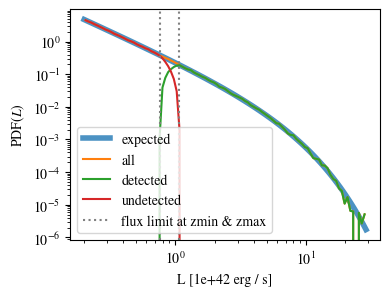

In [22]:
plt.figure(figsize=(4,3))
Ls = np.logspace(np.log10(lim.Lmin.to(luminosity_unit).value),
                 np.log10(np.nanmin([lim.Lmax.to(luminosity_unit).value, 1e6 * lim.Lmin.to(luminosity_unit).value])), 100)
n_bar_gal = quad(lim.luminosity_function, lim.Lmin.to(luminosity_unit).value, lim.Lmax.to(luminosity_unit).value)[0]
plt.plot(Ls, lim.luminosity_function(Ls) / n_bar_gal, label='expected', linewidth=4, alpha=0.8)
hist, bin_edges = np.histogram(lim.cat['luminosity'].to(luminosity_unit).value, bins=Ls, density=True)
hist_det, bin_edges = np.histogram(lim.cat['luminosity'][lim.cat['detected']].to(luminosity_unit).value, bins=Ls, density=True)
hist_undet, bin_edges = np.histogram(lim.cat['luminosity'][~lim.cat['detected']].to(luminosity_unit).value, bins=Ls, density=True)
plt.plot((Ls[:-1] + 0.5 * np.diff(Ls)), hist, label='all')
plt.plot(Ls[:-1] + 0.5 * np.diff(Ls), hist_det * (lim.N_gal_detected / lim.N_gal), label='detected')
plt.plot(Ls[:-1] + 0.5 * np.diff(Ls), hist_undet * (1-lim.N_gal_detected / lim.N_gal), label='undetected')

plt.axvline((lim.min_flux*(4*np.pi*lim.astropy_cosmo.luminosity_distance(lim.redshift+lim.delta_redshift)**2)).to(luminosity_unit).value,
              linestyle=':', color='gray')
plt.axvline((lim.min_flux*(4*np.pi*lim.astropy_cosmo.luminosity_distance(lim.redshift-lim.delta_redshift)**2)).to(luminosity_unit).value,
            linestyle=':', color='gray', label='flux limit at zmin & zmax')
plt.yscale("log")
plt.xscale("log")
plt.xlabel(f"L [{str(luminosity_unit)}]")
plt.ylabel(r"PDF($L$)")
plt.legend();

 make sure that the selection function is working

In [16]:
print("input min_flux: {:e}\nmin flux of the detected galaxies: {:e}".format(lim.min_flux, np.min(lim.cat['flux'][lim.cat['detected']])))
print("Any galaxies that are below the detection limit? {}.".format(np.min(lim.cat['flux'][lim.cat['detected']]) < lim.min_flux))

input min_flux: 3.000000e-17 erg / (cm2 s)
min flux of the detected galaxies: 3.000023e-17 erg / (cm2 s)
Any galaxies that are below the detection limit? False.


### Paint the intensity mesh 

using the redshift-space positions.

If you want to work in real space, exchange `RSD_Position` with `Position`.

In [17]:
intensity_mesh = lim.paint_intensity_mesh(position="RSD_Position");

Mesh assignment: finished 1/279646.
Mesh assignment: finished 100001/279646.
Mesh assignment: finished 200001/279646.
2023-07-12 09:51:17,069 simple WARNING: The smoothing length along or perpendicular to the LOS is smaller than the voxel size! You should consider using a larger smoothing length.


Plot the average intensity along the 3 different axes to visualize the smoothing:

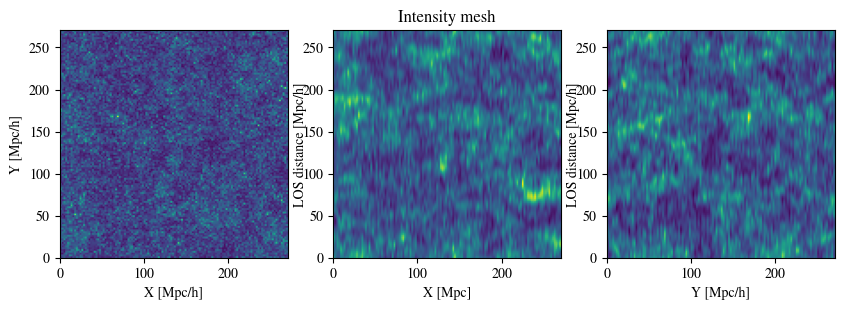

In [18]:
fig = plt.figure(figsize=(10,3))

ax1 = fig.add_subplot(131)
ax1.imshow(np.mean(lim.intensity_mesh.value, axis=0), 
           extent=[0,lim.box_size[1].value, 0, lim.box_size[2].value],
           origin='lower')
ax1.set_xlabel("X [Mpc/h]")
ax1.set_ylabel("Y [Mpc/h]")

ax2 = fig.add_subplot(132)
ax2.imshow(np.mean(lim.intensity_mesh.value, axis=1), 
           extent=[0,lim.box_size[1].value, 0, lim.box_size[2].value],
           origin='lower')
ax2.set_xlabel("X [Mpc]")
ax2.set_ylabel("LOS distance [Mpc/h]", labelpad=-3)
ax2.set_title("Intensity mesh")

ax3 = fig.add_subplot(133)
ax3.imshow(np.mean(lim.intensity_mesh.value, axis=2), 
           extent=[0,lim.box_size[1].value, 0, lim.box_size[2].value],
           origin='lower')
ax3.set_xlabel("Y [Mpc/h]")
ax3.set_ylabel("LOS distance [Mpc/h]", labelpad=-3);


### Get the intensity noise cube

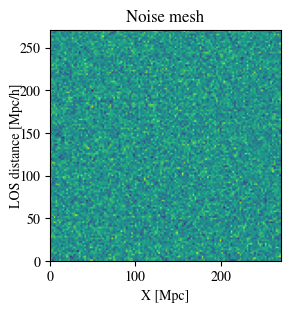

In [19]:
lim.get_intensity_noise_cube()
plt.figure(figsize=(3,3))
plt.imshow(np.mean(lim.noise_mesh.value, axis=1), 
           extent=[0,lim.box_size[1].value, 0, lim.box_size[2].value],
           origin='lower')
plt.xlabel("X [Mpc]")
plt.ylabel("LOS distance [Mpc/h]", labelpad=-3)
plt.title("Noise mesh");

### Plot the VID

Warning: numerical errors of the smoothing through FFT can cause some negative intensity values. This is especially true when the smoothing length is not much larger than the voxel size.

In [20]:
if lim.brightness_temperature:
    intensity_unit = u.uK / u.sr
    intensity_unit_str = r'$\mu$K'
else:
    try:
        lim.dnu
        intensity_unit = u.erg/u.s/u.cm**2/u.arcsec**2/u.Hz
        intensity_unit_str = r'$\mathrm{erg\, s^{-1}\, cm^{-2}\, arcsec}^{-2}\, \AA^{-1}$'
    except:
        intensity_unit = u.erg/u.s/u.cm**2/u.arcsec**2/u.angstrom
        intensity_unit_str = r'$\mathrm{erg\, s^{-1}\, cm^{-2}\, arcsec}^{-2}\, \AA^{-1}$'

In [21]:
log_I_bins = (np.linspace(0, 3, 100) * lim.mean_intensity).to(intensity_unit).value
vid, bin_edges = np.histogram(lim.intensity_mesh.to(intensity_unit).value, bins=log_I_bins, density=True)
vid_noise, bin_edges = np.histogram(lim.noise_mesh.to(intensity_unit).value, bins=log_I_bins, density=True)
vid_added, bin_edges = np.histogram((lim.intensity_mesh + lim.noise_mesh.to(lim.mean_intensity)).to(intensity_unit).value, bins=log_I_bins, density=True)

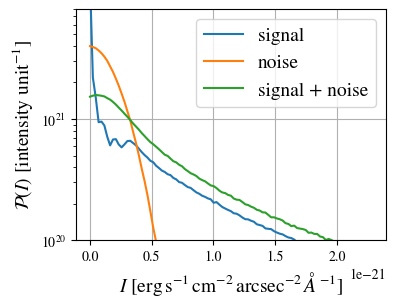

In [22]:
plt.figure(figsize=(4,3))
plt.plot(log_I_bins[:-1], vid, label='signal')
plt.plot(log_I_bins[:-1], vid_noise, label='noise')
plt.plot(log_I_bins[:-1], vid_added, label='signal + noise')

plt.yscale('log')
plt.xlabel(r'$I$ [{}]'.format(intensity_unit_str), fontsize=14)
plt.ylabel(r'$\mathcal{P}(I)$ [intensity unit$^{-1}$]', fontsize=14)
plt.grid()
plt.legend(fontsize=14)
plt.ylim(1e20, 8e21);

### Generate the galaxy number density mesh:

Mesh assignment: finished 1/55897.


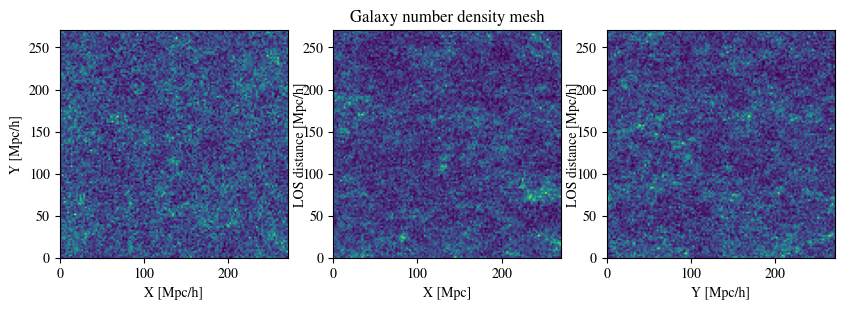

In [23]:
lim.paint_galaxy_mesh(position="RSD_Position")

fig = plt.figure(figsize=(10,3))
ax1 = fig.add_subplot(131)
ax1.imshow(np.mean(lim.n_gal_mesh.value, axis=0), 
           extent=[0,lim.box_size[1].value, 0, lim.box_size[2].value],
           origin='lower')
ax1.set_xlabel("X [Mpc/h]")
ax1.set_ylabel("Y [Mpc/h]")

ax2 = fig.add_subplot(132)
ax2.imshow(np.mean(lim.n_gal_mesh.value, axis=1), 
           extent=[0,lim.box_size[1].value, 0, lim.box_size[2].value],
           origin='lower')
ax2.set_xlabel("X [Mpc]")
ax2.set_ylabel("LOS distance [Mpc/h]", labelpad=-3)
ax2.set_title("Galaxy number density mesh")

ax3 = fig.add_subplot(133)
ax3.imshow(np.mean(lim.n_gal_mesh.value, axis=2), 
           extent=[0,lim.box_size[1].value, 0, lim.box_size[2].value],
           origin='lower')
ax3.set_xlabel("Y [Mpc/h]")
ax3.set_ylabel("LOS distance [Mpc/h]", labelpad=-3);

### Save the LognormalIntensityMock instance and catalog to files:

In [24]:
filename = os.path.join(
                lim.out_dir,
                "lognormal",
                "rsd",
                lim.outfile_prefix + "_lim_instance.h5",
            )
catalog_filename = os.path.join(
    lim.out_dir, "lognormal", lim.outfile_prefix + "_lognormal_rlz0.h5"
)
lim.save_to_file(filename=filename,
                              catalog_filename=catalog_filename)

### Initiate a LognormalIntensityMock instance from a file:

In [25]:
lim = LognormalIntensityMock.from_file(filename = filename, catalog_filename = catalog_filename)

2023-07-12 09:51:19,673 simple WARNING: We extrapolate the values outside of the provided tabulated values of L.
Plot plt.loglog(Ls, lim.luminosity_function(Ls)) in a reasonable range to check the outcome!


### Calculate the power spectrum multipoles:

THe units $u_A$ are $u_\mathrm{g} = 1$ and $u_I = \langle I \rangle$.

In [26]:
monopoles = {}
mean_ks = {}
quadrupoles = {}

for tracer in ["intensity", "n_gal", "cross", "sky_subtracted_intensity", "sky_subtracted_cross"]:
    mean_ks[tracer], monopoles[tracer], quadrupoles[tracer] = lim.Pk_multipoles(tracer=tracer, save=True)

/Users/maja/Documents/projects/intensity-mapping/simple/simple/tools_python.py:345: RuntimeWarning: invalid value encountered in true_divide
  return np.where(x != 0, j1(x) / x, 0.5)


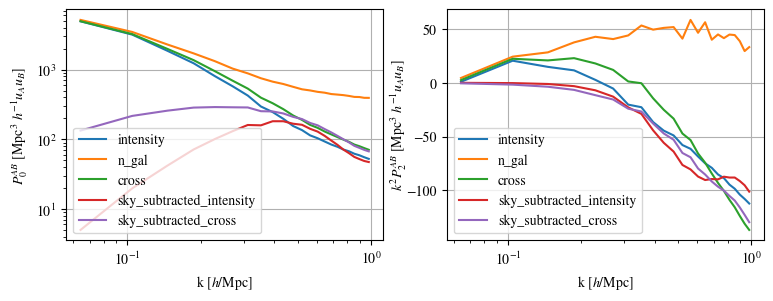

In [27]:
fig = plt.figure(figsize=(9,3))
ax1 = fig.add_subplot(121)
for tracer in ["intensity", "n_gal", "cross", "sky_subtracted_intensity", "sky_subtracted_cross"]:
    ax1.plot(mean_ks[tracer], monopoles[tracer], label=tracer)

ax2 = fig.add_subplot(122)
for tracer in ["intensity", "n_gal", "cross", "sky_subtracted_intensity", "sky_subtracted_cross"]:
    ax2.plot(mean_ks[tracer], mean_ks[tracer]**2 * quadrupoles[tracer], label=tracer)

ax1.set_yscale("log")
ax1.set_xscale("log")
ax1.legend()
ax1.grid()
ax1.set_xlabel(r"k [$h$/Mpc]")
ax1.set_ylabel(r"$P_0^{AB}$ [Mpc$^3$ $h^{-1}u_A u_B$]")

ax2.set_xscale("log")
ax2.legend()
ax2.grid()
ax2.set_xlabel(r"k [$h$/Mpc]")
ax2.set_ylabel(r"$k^2 P_2^{AB}$ [Mpc$^3$ $h^{-1}u_A u_B$]", labelpad=-2);

For the power spectrum, we need to calculate the mean intensity per redshift and the mean galaxy number density per redshift.
We can check that it is working by calling `lim.mean_intensity_per_redshift(lim.redshift_mesh_axis, tracer='intensity')` or `lim.mean_intensity_per_redshift(lim.redshift_mesh_axis, tracer='n_gal')`

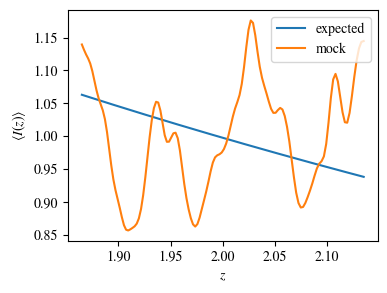

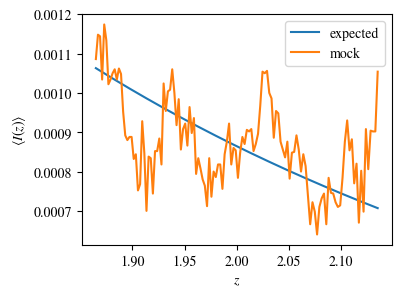

In [28]:
plt.figure(figsize=(4,3))
plt.plot(lim.redshift_mesh_axis, lim.mean_intensity_per_redshift_mesh.to(lim.mean_intensity)[:,0,0], label='expected')
plt.plot(lim.redshift_mesh_axis, np.mean(lim.intensity_mesh, axis=(1,2)).to(lim.mean_intensity), label='mock')
plt.xlabel(r"$z$")
plt.ylabel(r"$\langle I(z)\rangle$")
plt.legend()

plt.figure(figsize=(4,3))
plt.plot(lim.redshift_mesh_axis, lim.mean_ngal_per_redshift_mesh.to(u.Mpc**-3)[:,0,0], label='expected')
plt.plot(lim.redshift_mesh_axis, np.mean(lim.n_gal_mesh, axis=(1,2)).to(u.Mpc**-3), label='mock')
plt.xlabel(r"$z$")
plt.ylabel(r"$\langle I(z)\rangle$")
plt.legend();

## Run everything in one step

You can also do everything in one step if the input dictionary is complete:

In [29]:
lim.run()

[0.   0.   0.06] eV
{'ofile_prefix': 'mock', 'inp_pk_fname': '../tmp/mocks/inputs/mock_pk.txt', 'xi_fname': '../tmp/mocks/inputs/mock_Rh_xi.txt', 'pkg_fname': '../tmp/mocks/inputs/mock_pkG.dat', 'mpkg_fname': '../tmp/mocks/inputs/mock_mpkG.dat', 'cpkg_fname': '../tmp/mocks/inputs/mock_mpkG.dat', 'f_fname': '../tmp/mocks/inputs/mock_fnu.txt', 'z': 2.0, 'mnu': 0.06, 'oc0h2': 0.11934063901639999, 'ob0h2': 0.0224178568132, 'ns': 0.9645, 'lnAs': 3.094, 'h0': <Quantity 0.6766>, 'w': -1.0, 'run': 0.0, 'bias': 1.5, 'bias_mpkG': 1.0, 'bias_cpkG': 1.35, 'Nrealization': 1, 'Ngalaxies': 279657, 'Lx': 270.6403431715201, 'Ly': 270.6403431715201, 'Lz': 270.6403431715201, 'rmax': 10000.0, 'seed': 100, 'Pnmax': 128, 'losy': 0.0, 'losz': 0.0, 'kbin': 0.01, 'kmax': 0.0, 'lmax': 4, 'gen_inputs': True, 'run_lognormal': True, 'calc_pk': False, 'calc_cpk': False, 'use_cpkG': 0, 'output_matter': 0, 'output_gal': 1, 'calc_mode_pk': 0, 'out_dir': '../tmp/mocks/', 'halofname_prefix': '', 'imul_fname': '', 'num_p

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG

real	0m0.015s
user	0m0.005s
sys	0m0.005s

real	0m0.033s
user	0m0.027s
sys	0m0.004s

real	0m0.021s
user	0m0.015s
sys	0m0.004s

real	0m0.022s
user	0m0.015s
sys	0m0.004s


Finished generating mock density field.
Doing FFT for density field.
Done FFT for density field.
Average of Log-normal density field  :-1.74366e-09
Variance of Log-normal density field :1568.33
Average of Log-normal density field  :-8.31441e-16
Variance of Log-normal density field :1.08298
Average of matter Log-normal density field :7.25929e-11
Variance of matter Log-normal density field :1197.7
Average of matter Log-normal density field :3.4615e-17
Variance of matter Log-normal density field :0.82705
density maximum = 153.52
density minimum = -0.997805
Average of density field: 0.00100348
Variance of density field: 2.26557
Doing FFT for the density field.
Calculating velocity field in Fourier space...
Doing FFT for the vx field.
Doing FFT for the vy field.
Doing FFT for the vz field.
Initializing random generater..
checkpoint 1
Ngalaxies 279657
checkpoint 2
checkpoint 3
checkpoint 4
final_array_length 3355884
checkpoint 5: allocated array.
Generating Poisson particles...........
ngalb


real	0m0.197s
user	0m0.242s
sys	0m0.024s


Mesh assignment: finished 1/279646.
Mesh assignment: finished 100001/279646.
Mesh assignment: finished 200001/279646.
2023-07-12 09:51:23,729 simple WARNING: The smoothing length along or perpendicular to the LOS is smaller than the voxel size! You should consider using a larger smoothing length.
Mesh assignment: finished 1/55934.
